# HW2 

In this homework we look at a (naive but we will get better) way of computing homographies between images. 

1. image1 shows a picture on a wall. Our goal is to replace that picture with image2. 
In order to do this we will compute the H matrix that defines the transformation between the two images and then map image2 in place on image1. 

Several things to consider. You can use the four corner points in each image to setup up the computation of the H matrix and then map every pixel as needed.


Please write up your work and put all your code in a python notebook and check into  your class Gitlab folder

Note 0: Feel free to use a cursor to hand pick the corners in the image

Note 1: Pixel values may not fall on exact integer values. You can use the following call (or something like it to warp the image).

```
# Warp source image to destination based on homography
im_out = cv2.warpPerspective(im_src, h,(im_dst.shape[1],im_dst.shape[0]))
```

Note 2: Of course we can do the homography calculation very easily in openCV as well with the following call (below) but in this homework we want to peek under the hood and figure it out for ourselves. 

```
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)
```


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
def bgr_to_rgb(bgr_img):
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    return rgb_img

In [3]:
img1 = cv2.imread('image1.jpg')
img1 = bgr_to_rgb(img1)
img2 = cv2.imread('image2.jpg')
img2 = bgr_to_rgb(img2)

<IPython.core.display.Javascript object>


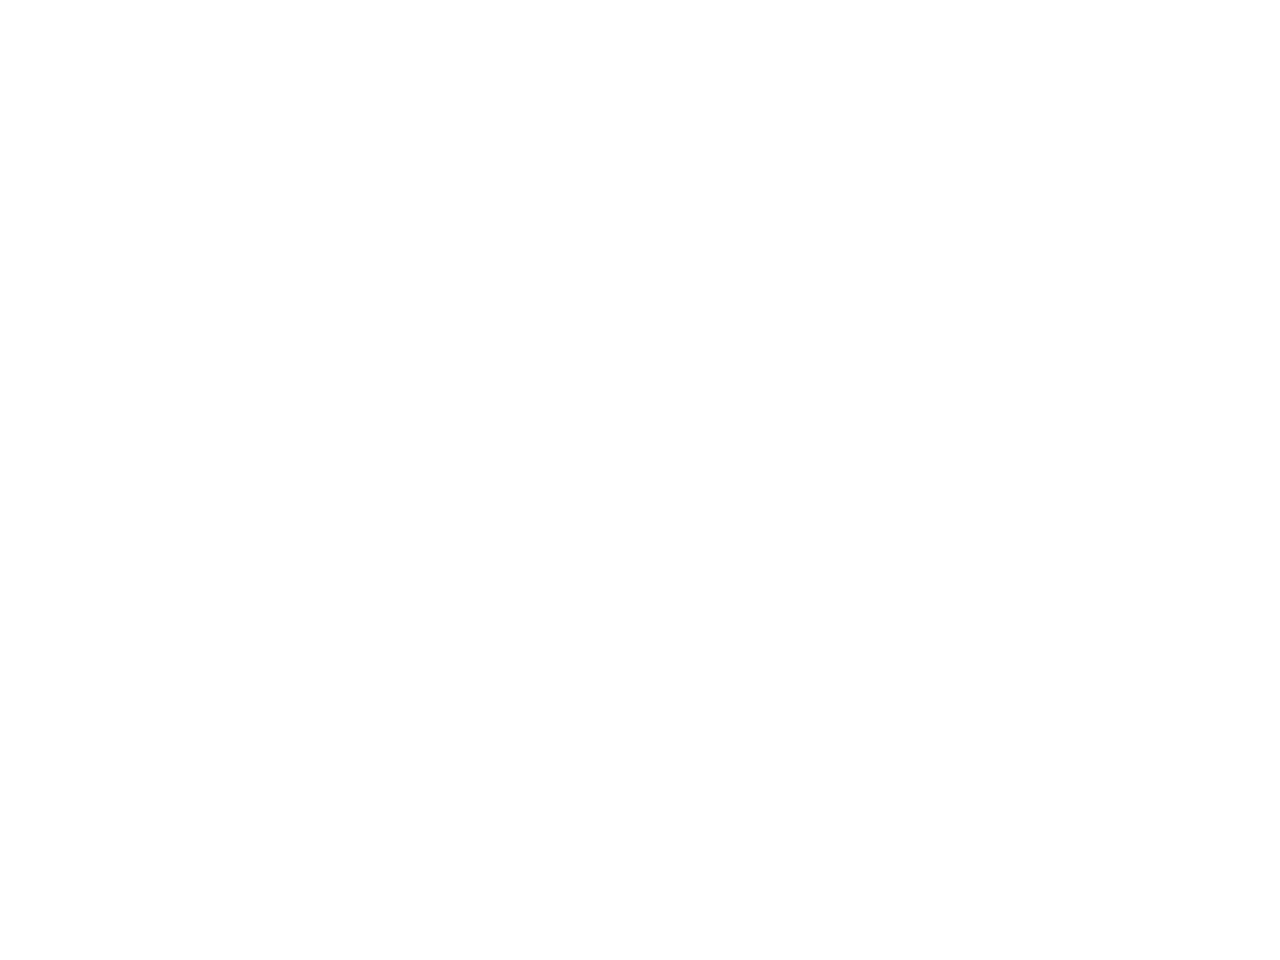

<IPython.core.display.Javascript object>


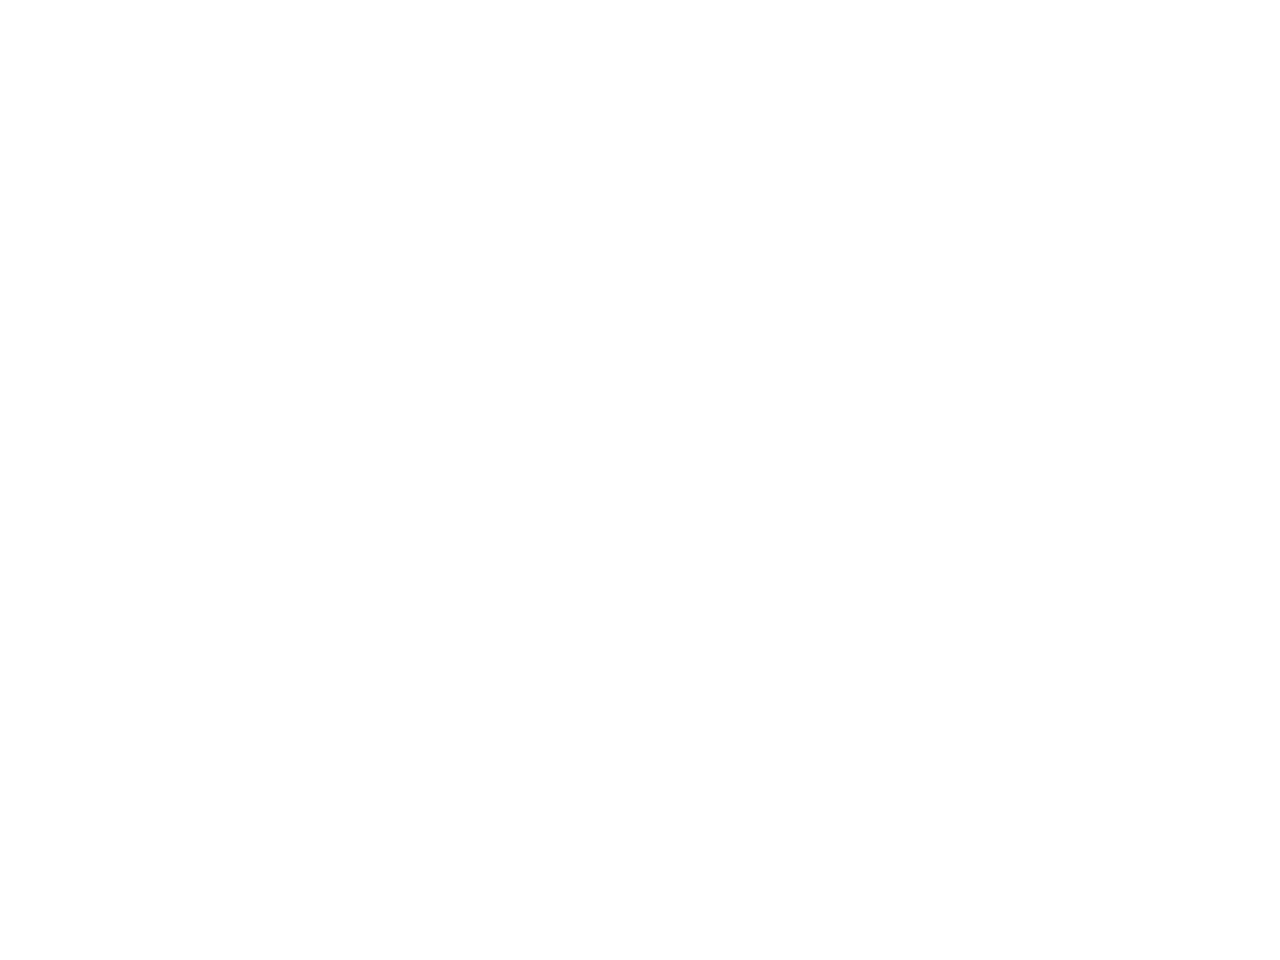

In [4]:
# Make Matplotlib interactive so I can handpick points
%matplotlib notebook

plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)


plt.show()

In [5]:
# Okay enough of that. Please reset it to be normal again. 
%matplotlib inline
Point = namedtuple('Point', 'x y')


# Handpicked Points from Image 1
image1_tl = Point(515, 482)
image1_tr = Point(941, 436)
image1_bl = Point(550, 1103)
image1_br = Point(968, 1168)
image1_points = [image1_tl, image1_tr, image1_bl, image1_br]

# Handpicked Points from Image 2
image2_tl = Point(51, 128)
image2_tr = Point(370, 128)
image2_bl = Point(35, 386)
image2_br = Point(386, 386)
# Alternatively, use the entire image
height, width, channels = img2.shape
image2_tl = Point(0, 0)
image2_tr = Point(width, 0)
image2_bl = Point(0, height)
image2_br = Point(width, height)
image2_points = [image2_tl, image2_tr, image2_bl, image2_br]


Construct the following. 
![H_equation](h_equation.png)

In [6]:
def make_x_row(point1: Point, point2: Point):
    return np.array([point1.x, point1.y, 1, 0, 0, 0, -point1.x*point2.x, -point1.y*point2.x])

def make_y_row(point1: Point, point2: Point):
    return np.array([0, 0, 0, point1.x, point1.y, 1, -point1.x*point2.y, -point1.y*point2.y])

def make_a(points1, points2):
    assert(len(points1) == len(points2))
    A = None
    
    for index in range(len(points1)): 
        x_row = make_x_row(points1[index], points2[index])
        y_row = make_y_row(points1[index], points2[index])
        if A is None:
            A = np.array([x_row, y_row]) 
        else:
            A = np.vstack([A, x_row, y_row])
    return A

def make_b(points2):
    b = []
    
    for point in points2:
        b.append(point.x)
        b.append(point.y)

    return b

Solve for H using the following. 
![H_equation2](h_equation2.png)

| Matlab     | Numpy                     | Description |
|:-----------|---------------------------|-------------|
|a\b	     |linalg.solve(a,b) if a is square; linalg.lstsq(a,b) otherwise| 	solution of a x = b for x|

In [7]:
def isSquare (m): 
    return all (len (row) == len (m) for row in m)

def find_h(A, b):
    if isSquare(A):
        H = np.linalg.solve(A, b)
    else:
        result = np.linalg.lstsq(A,b,rcond=None)
        H = result[0]
        print(H)
        
    H = np.append(H, [1])
    H = np.reshape(H, (3, 3))
    return H



In [8]:
A = make_a(image2_points, image1_points)
b = make_b(image1_points)

print("A: \n" + str(A))
print("b: \n" + str(b))

H = find_h(A, b)

print("H: \n" + str(H))

A: 
[[      0       0       1       0       0       0       0       0]
 [      0       0       0       0       0       1       0       0]
 [    450       0       1       0       0       0 -423450       0]
 [      0       0       0     450       0       1 -196200       0]
 [      0     446       1       0       0       0       0 -245300]
 [      0       0       0       0     446       1       0 -491938]
 [    450     446       1       0       0       0 -435600 -431728]
 [      0       0       0     450     446       1 -525600 -520928]]
b: 
[515, 482, 941, 436, 550, 1103, 968, 1168]
H: 
[[ 6.24168381e-01  1.14361671e-01  5.15000000e+02]
 [-2.51647571e-01  1.46434510e+00  4.82000000e+02]
 [-3.42718689e-04  6.52478816e-05  1.00000000e+00]]


`H` now holds the Homography from image2 into image1

In [9]:
def convert_points(points):
    pts = [[point.x, point.y] for point in points]
    return np.array(pts)

def check_h(H, pts_src, pts_dest):
    h, status = cv2.findHomography(convert_points(pts_src), convert_points(pts_dest))
    diff = sum(sum(h-H))
    if abs(diff) < 1:
        print("H is good!")
        return H
    else:
        print("H is not good!")
        return h

    print("Diff of {}".format(diff))

check_h(H, image2_points, image1_points)

H is good!


array([[ 6.24168381e-01,  1.14361671e-01,  5.15000000e+02],
       [-2.51647571e-01,  1.46434510e+00,  4.82000000e+02],
       [-3.42718689e-04,  6.52478816e-05,  1.00000000e+00]])

the warped image
Intended Canvas


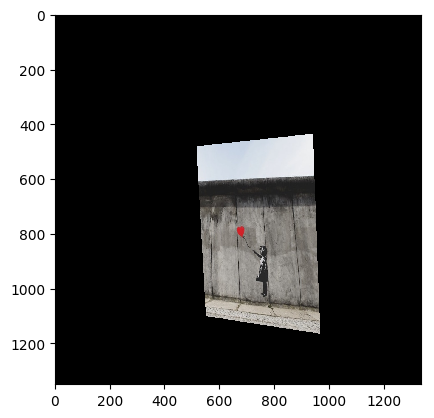

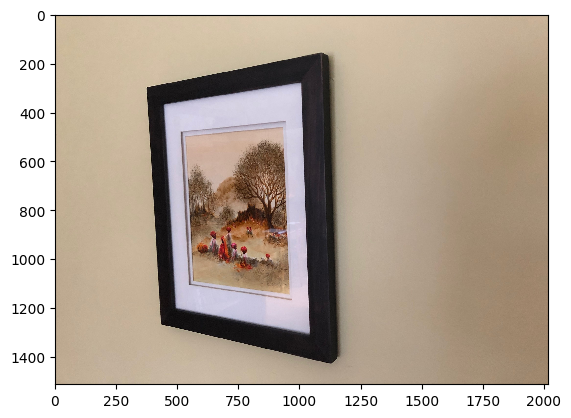

In [10]:
im_height, im_width, channels = img2.shape
scale = 3
print("the warped image")
plt.figure()
im_out = None
im_out = cv2.warpPerspective(img2, H, (im_height*scale, im_width*scale), borderMode=cv2.BORDER_TRANSPARENT)
plt.imshow(im_out)

print("Intended Canvas")
plt.figure()
plt.imshow(img1)

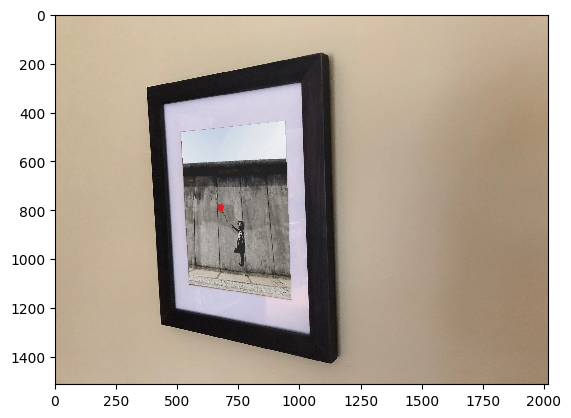

In [11]:
def combine_images(image1, image2, anchor_y=0, anchor_x=0):
    # https://stackoverflow.com/questions/48979219/cv2-composting-2-images-of-differing-size
    
    foreground, background = image1.copy(), image2.copy()
    # Check if the foreground is inbound with the new coordinates and raise an error if out of bounds
    background_height = background.shape[1]
    background_width = background.shape[1]
    foreground_height = foreground.shape[0]
    foreground_width = foreground.shape[1]
    if foreground_height+anchor_y > background_height or foreground_width+anchor_x > background_width:
        raise ValueError("The foreground image exceeds the background boundaries at this location")

    alpha =.8

    # do composite at specified location
    start_y = anchor_y
    start_x = anchor_x
    end_y = anchor_y+foreground_height
    end_x = anchor_x+foreground_width
    blended_portion = cv2.addWeighted(foreground,
                alpha,
                background[start_y:end_y, start_x:end_x,:],
                1 - alpha,
                0,
                background)
    background[start_y:end_y, start_x:end_x,:] = blended_portion
    return background

def combine_via_mask(image1, image2, mask):
    #https://stackoverflow.com/questions/51365126/combine-2-images-with-mask
    combined = image2.copy()
    combined[np.where(mask == 255)] = image1[np.where(mask == 255)]
    return combined

# Threshold the HSV image to get only black colors
black_mask = cv2.inRange(im_out, 0, 0)
im_mask = cv2.bitwise_not(black_mask)

combined = combine_via_mask(im_out, img1, im_mask) 
plt.imshow(combined)

2. Given what we learned about homographies and how they warp images can you pick four additional points from the two images. How would you modify the computation of the H matrix when you have an overconstrained problem (8 points as opposed to 4). Recompute H with these 8 points and comment on the differences in the H matrix. Map image3 on image1 as well with this new homography.

In [12]:
def mean(a, b):
    return float(a + b)/2

# Handpicked Points from Image 1
image1_tl = Point(515, 482)
image1_tr = Point(941, 436)
image1_bl = Point(550, 1103)
image1_br = Point(968, 1168)
image1_tm = Point(mean(image1_tl.x, image1_tr.x), 0)
image1_bm = Point(mean(image1_tl.x, image1_tr.x), height)
image1_rm = Point(width, mean(image1_tr.y, image1_br.y))
image1_lm = Point(0, mean(image1_tl.y, image1_bl.y))
image1_points = [image1_tl, image1_tm, image1_tr, image1_bl, image1_bm, image1_br, image1_rm, image1_lm]


# Handpicked Points from Image 2
# Alternatively, use the entire image
height, width, channels = img2.shape
image2_tl = Point(0, 0)
image2_tm = Point(width/2, 0)
image2_tr = Point(width, 0)
image2_bl = Point(0, height)
image2_bm = Point(width/2, height)
image2_br = Point(width, height)
image2_rm = Point(width, height/2)
image2_lm = Point(0, height/2)
image2_points = [image2_tl, image2_tm, image2_tr, image2_bl, image2_bm, image2_br, image2_rm, image2_lm]



In [13]:
A = make_a(image2_points, image1_points)
b = make_b(image1_points)
H = find_h(A, b)
h = check_h(H, image2_points, image1_points)
H = h

[-3.91730497e-01 -1.25069627e+00  5.22862929e+02 -1.02354921e+00
 -6.13241571e-01  4.98965761e+02 -1.25322814e-03 -1.71725808e-03]
H is not good!


the warped image
Intended Canvas


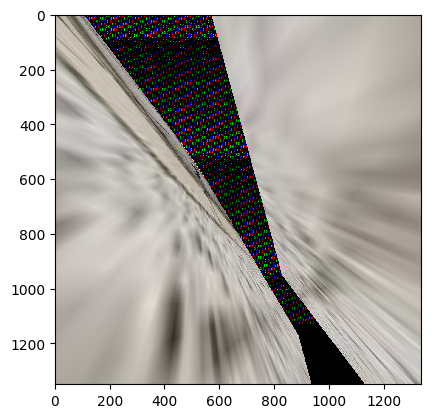

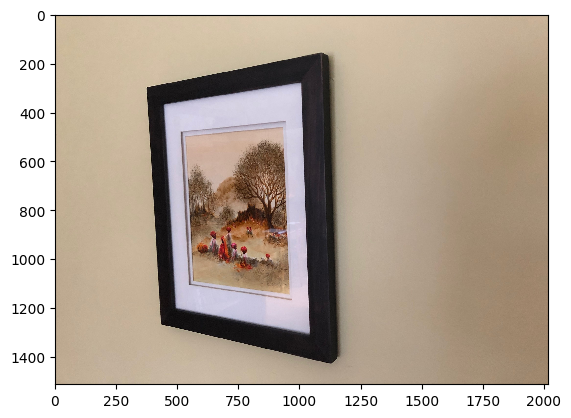

In [14]:
im_height, im_width, channels = img2.shape
scale = 3
print("the warped image")
plt.figure()
im_out = None
im_out = cv2.warpPerspective(img2, H, (im_height*scale, im_width*scale), borderMode=cv2.BORDER_TRANSPARENT)
plt.imshow(im_out)

print("Intended Canvas")
plt.figure()
plt.imshow(img1)

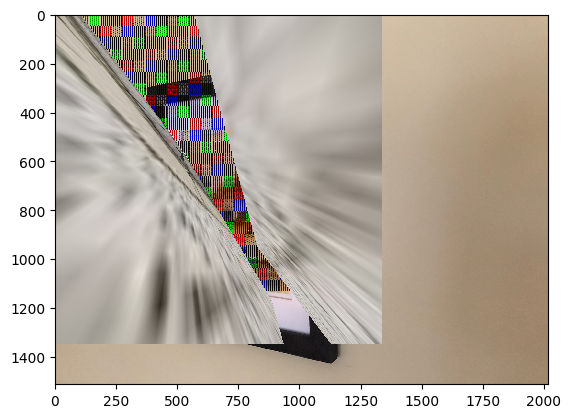

In [15]:
# Threshold the HSV image to get only black colors
black_mask = cv2.inRange(im_out, 0, 0)
im_mask = cv2.bitwise_not(black_mask)

plt.figure()
combined = combine_via_mask(im_out, img1, im_mask) 
plt.imshow(combined)

3. Can you now take multiple images (five?) and stitch them together into a mosaic. Try and stand in a spot and rotate the camera to take multiple overlapping images and then compute the homographies and map the images onto each other while blending them.
Again we are picking four points common across each image. 

Think about how you would pick the points – collinearity, spacing etc. 

To do a simple blend you can follow the instructions here. 
https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html


Also here is a hint for your panorama: Use the center image as image 0 and map the homographies from the center outwards.

In [16]:
# Load images for panorama
folder = "imgs/"
fns = ['m1', 'm2', 'm3', 'm4', 'm5']
ftype = ".JPG"
imgs = {}

for file in fns:
    filename = folder + file + ftype
    imgs[file] = cv2.imread(filename)
    imgs[file] = bgr_to_rgb(imgs[file])

<IPython.core.display.Javascript object>


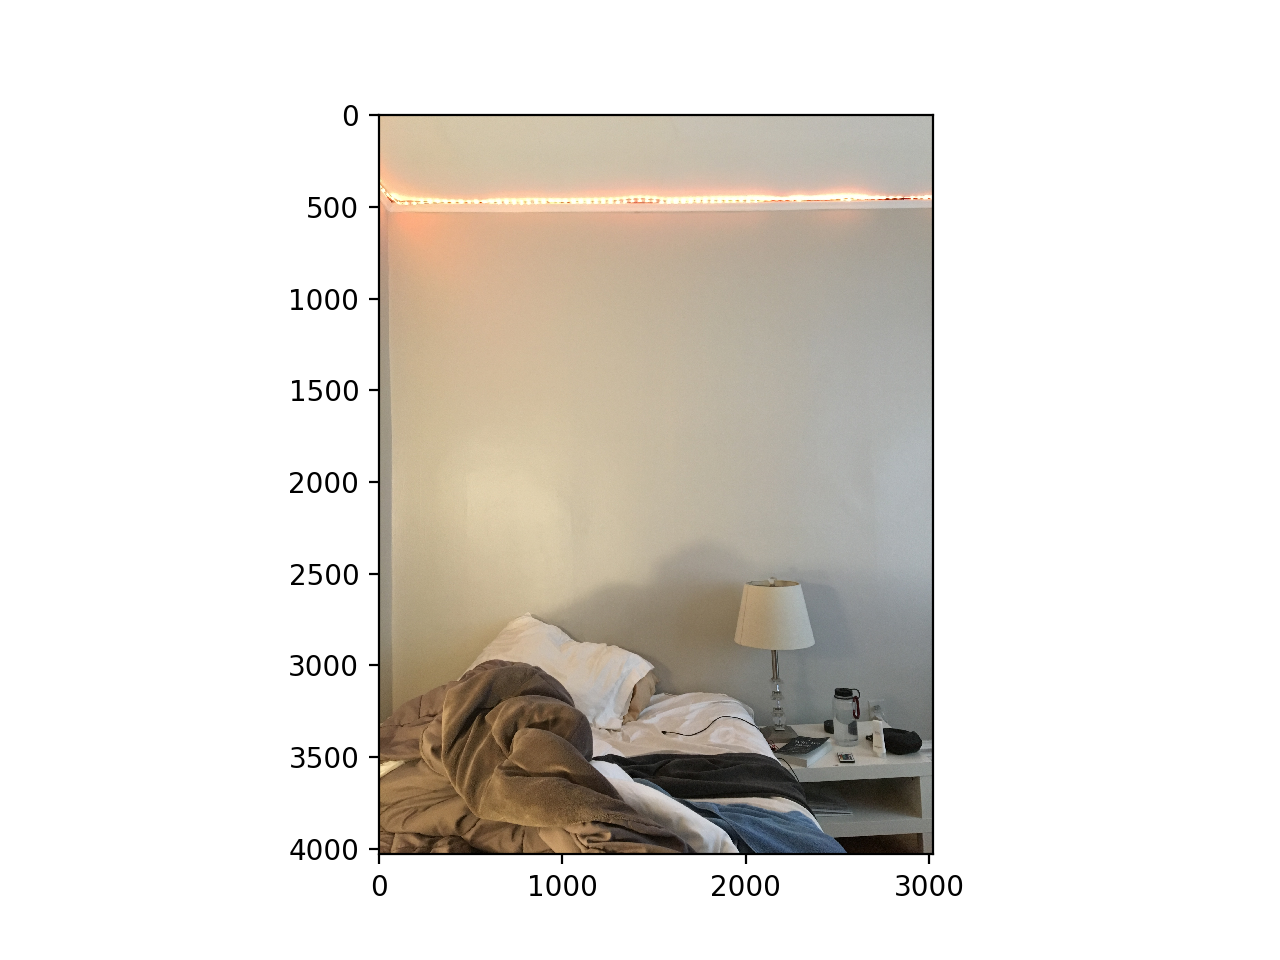

<IPython.core.display.Javascript object>


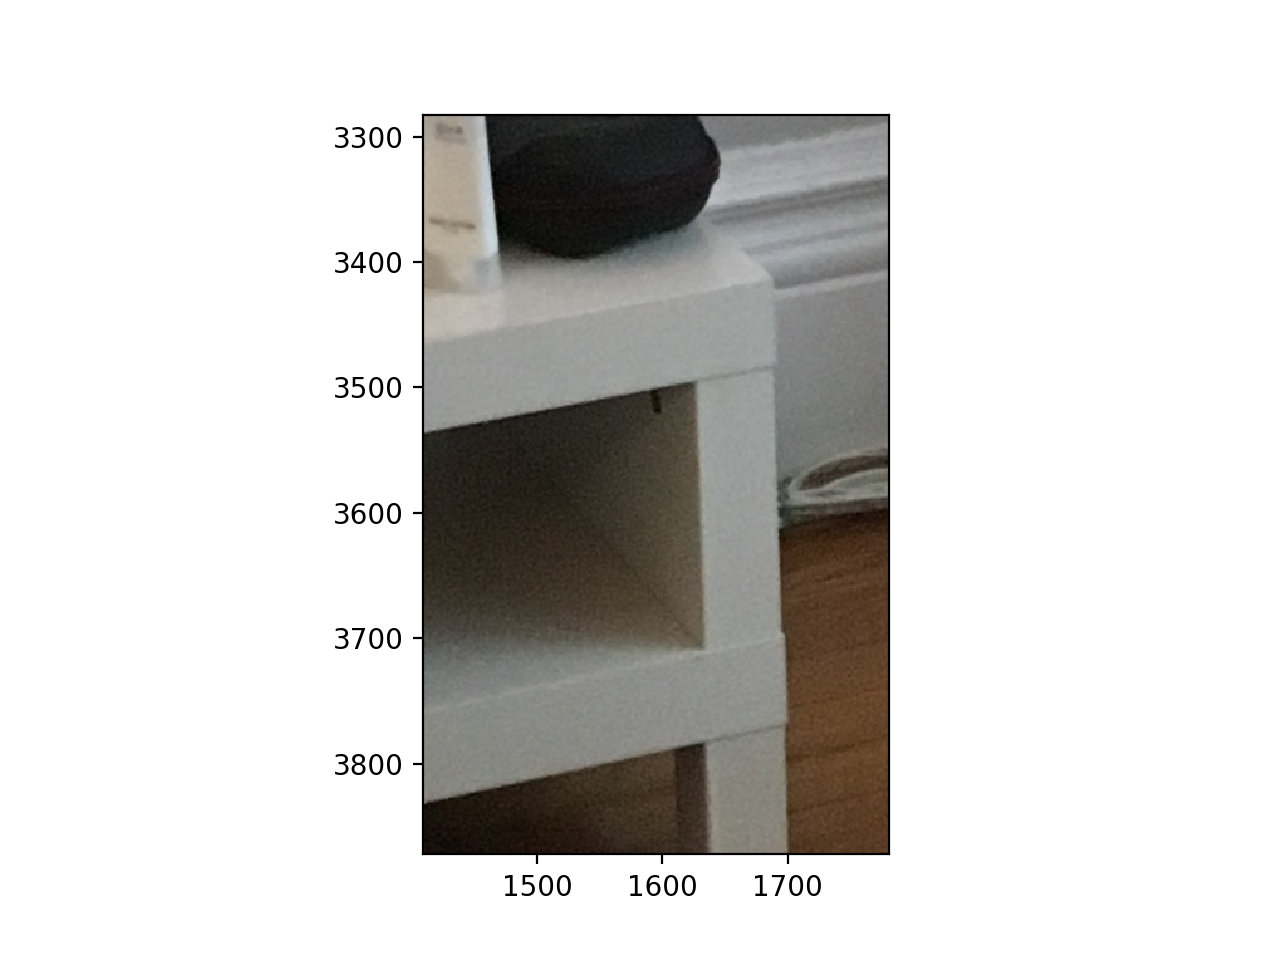

<IPython.core.display.Javascript object>


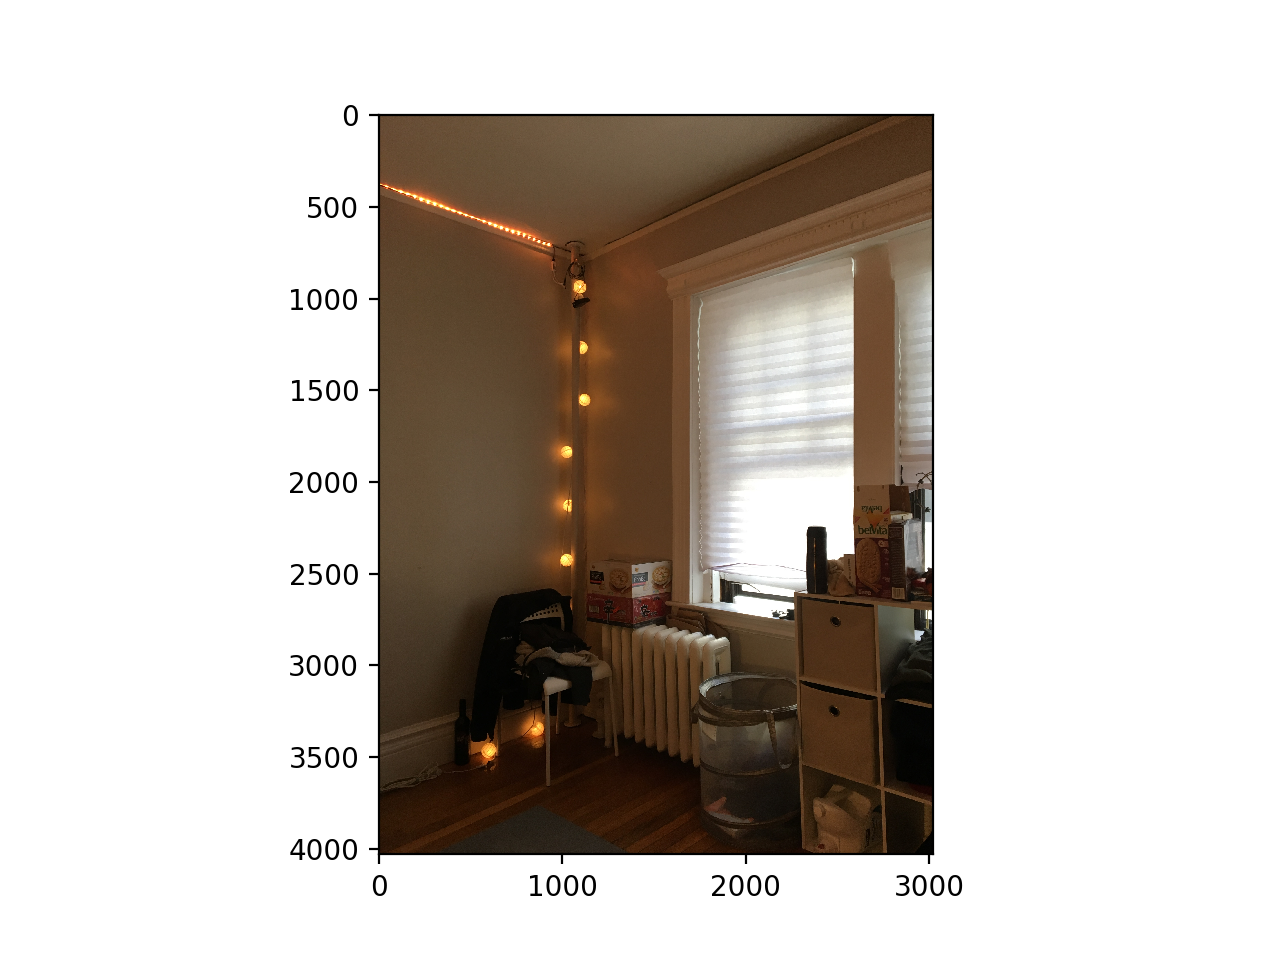

<IPython.core.display.Javascript object>


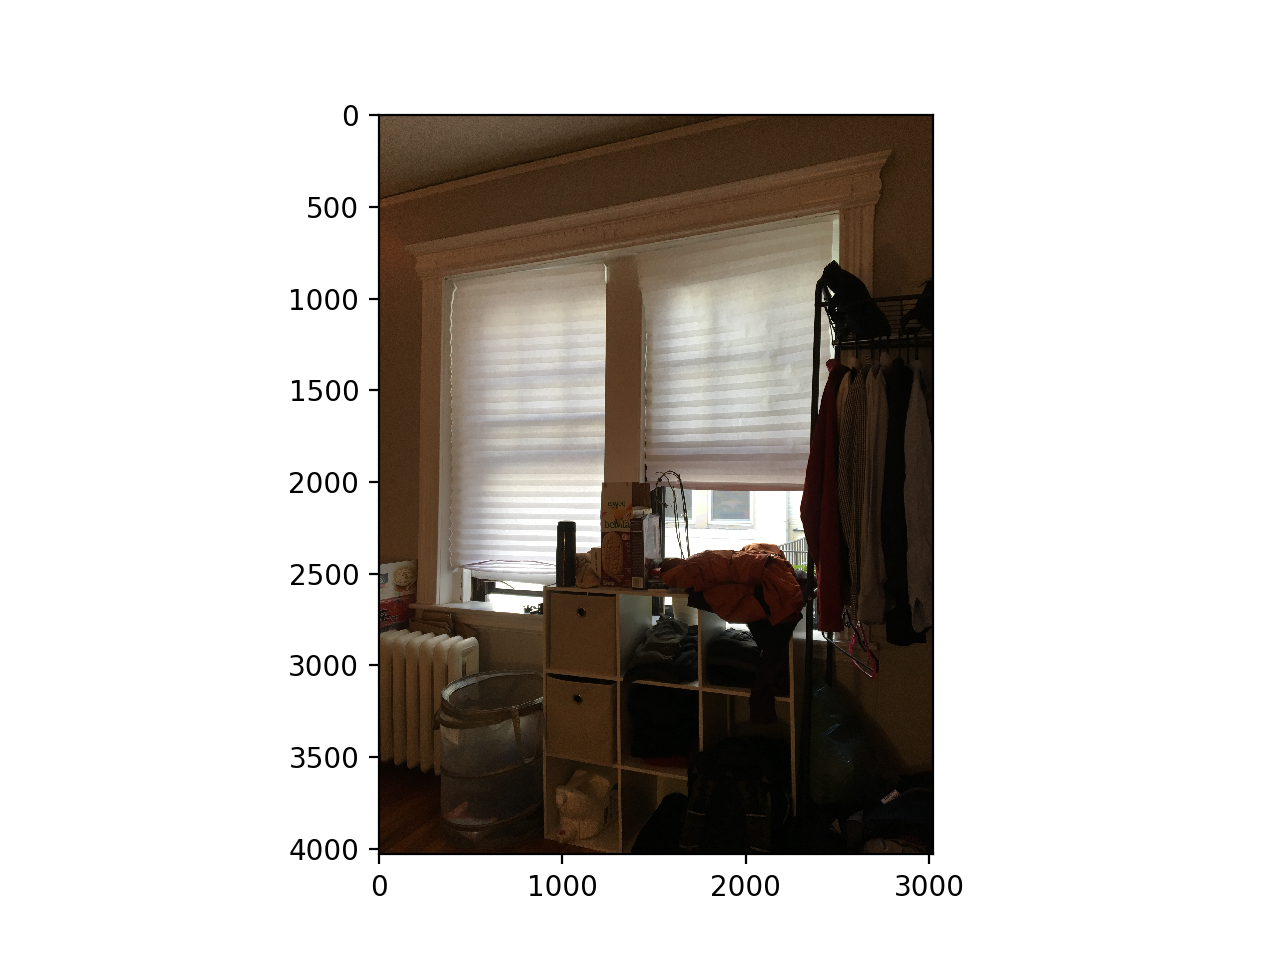

<IPython.core.display.Javascript object>


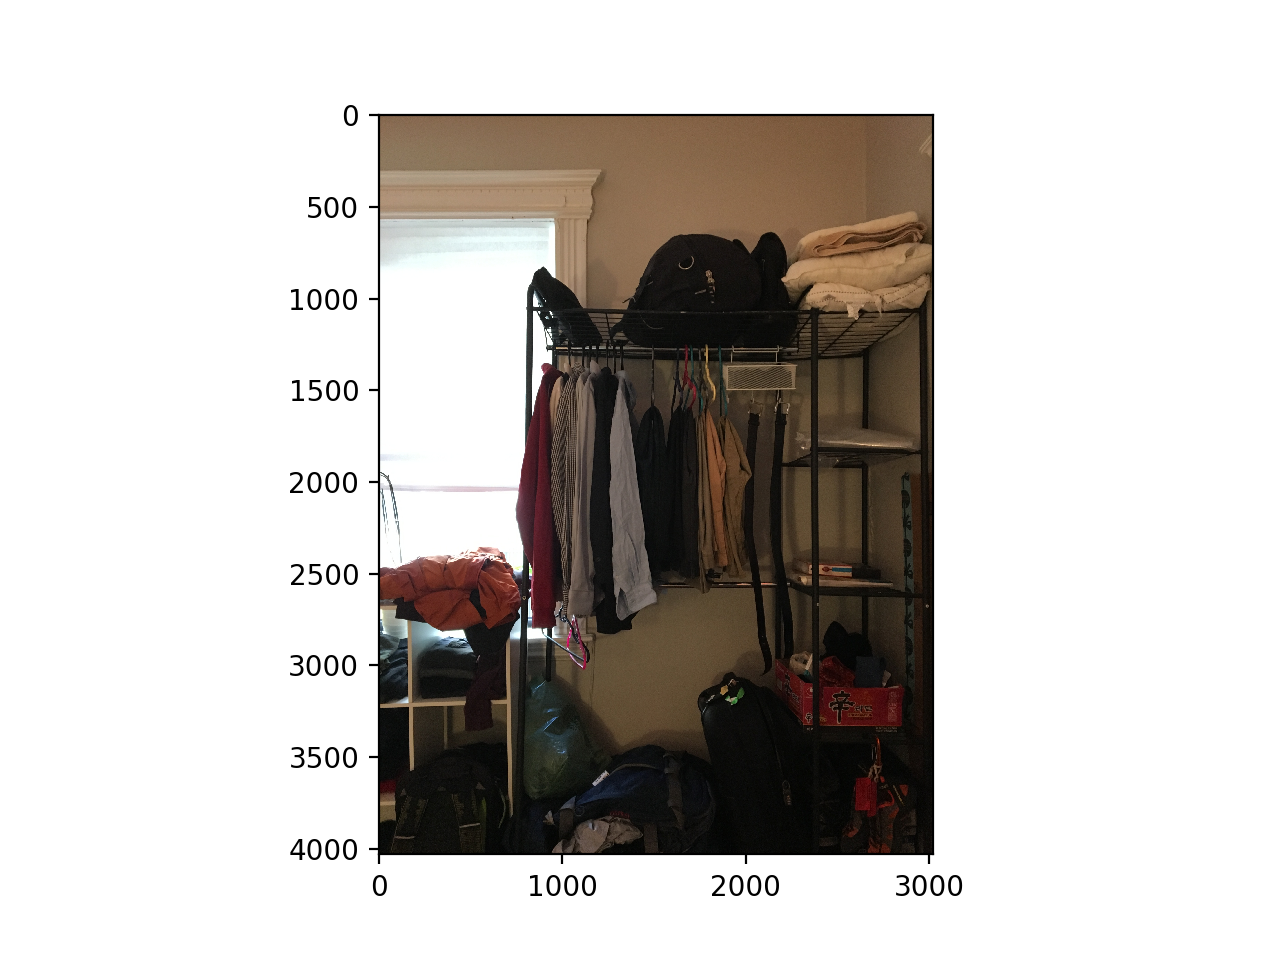

In [19]:
# Make Matplotlib interactive so I can handpick points
%matplotlib notebook
for file in fns:
    plt.figure()
    plt.imshow(imgs[file])

plt.show()

In [24]:
%matplotlib inline

# Get all the hand picked points
im3_to_4 = { 
    "im4": [
        Point(130, 720),
        Point(311, 2675),
        Point(1240, 830),
        Point(1386, 2209)
    ],
    "im3": [
        Point(1515, 854),
        Point(1692, 2664),
        Point(2588, 797),
        Point(2272, 2240)
    ]
}

im4_to_5 = {
    "im4": [
        Point(2794, 200),
        Point(1760, 3120),
        Point(2240, 3180),
        Point(2841, 1015)
    ],
    "im5": [
    Point(1210, 303),
    Point(181, 3207),
    Point(696, 3190),
    Point(1234, 1086)]
}

im3_to_2 = {
    "im3": [
        Point(922, 3660),
        Point(1298, 3500),
        Point(1220, 2495), 
        Point(1108, 772)
    ],
    "im2": [
        Point(2576, 3736),
        Point(2983, 3643),
        Point(2855, 2545),
        Point(2681, 727)
    ]
}
im2_to_1 = {
    "im2": [
        Point(229, 3430),
        Point(919, 2508),
        Point(1630, 3781),
        Point(1621, 3490)
    ],
    "im1": [
        Point(1548, 3676),
        Point(2142, 2520),
        Point(2940, 3606),
        Point(2961, 3914)
    ]
}

Now we want to paint im2 into im3 and im4 into im3.

In [35]:
PanoramaStuff = namedtuple("PanoramaStuff", ("image points"))

def make_panorama(src: PanoramaStuff, dest: PanoramaStuff):
    A = make_a(src.points, dest.points)
    b = make_b(dest.points)
    H = find_h(A, b)
    h = check_h(H, src.points, dest.points)
    H = h
    im_height, im_width, channels = src.image.shape
    scale = 1
    print("the warped image")
    plt.figure()
    im_out = None
    im_out = cv2.warpPerspective(src.image, H, (im_height*scale, im_width*scale), borderMode=cv2.BORDER_TRANSPARENT)
    plt.imshow(im_out)

    # Threshold the HSV image to get only black colors
    black_mask = cv2.inRange(im_out, 0, 0)
    im_mask = cv2.bitwise_not(black_mask)

    # combined = combine_via_mask(im_out, dest.image, im_mask)
    combined = combine_images(im_out, dest.image);

H is good!
the warped image


ValueError: The foreground image exceeds the background boundaries at this location

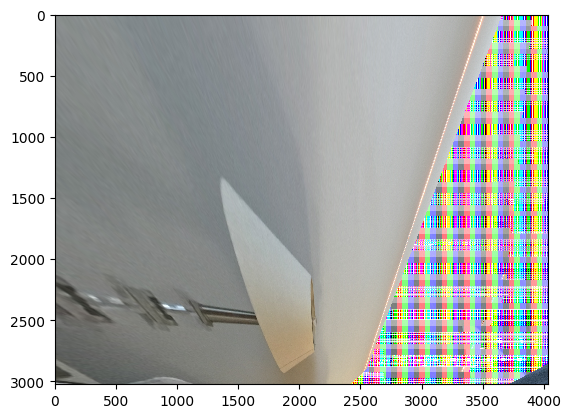

In [41]:
im1_2_1 = PanoramaStuff(imgs["m1"], im2_to_1["im1"])
im1_2_2 = PanoramaStuff(imgs["m2"], im2_to_1["im2"])

im12 = make_panorama(im1_2_2, im1_2_1)


im3_2_3 = PanoramaStuff(imgs["m3"], im3_to_2["im3"])
im3_2_2 = PanoramaStuff(imgs["m2"], im3_to_2["im2"])

im32 = make_panorama(im3_2_2, im3_2_3)

im3_4_3 = PanoramaStuff(imgs["m3"], im3_to_4["im3"])
im3_4_4 = PanoramaStuff(imgs["m4"], im3_to_4["im4"])

im34 = make_panorama(im3_4_4, im3_4_3)

### On the topic of blending check out the classic paper by Burt and Adelson (attached)

And the real imagery that goes with it
http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/Pyramids.pdf

In your python notebook write a 4-5 line explanation of how this method differs from the link above. 

## Comparing Blending Techniques
There are a couple of differences from the basic linear blending presented in the OpenCV documenation 
and the multiresolution spline presented in "A Multiresolution Spline With Application to Image Mosaics". 

The OpenCV function `addWeighted` simply takes two images and combines them by setting the value of each
pixel in the overlapping area equal to a constant ratio given by $\alpha$. 

This differes from the Multiresolution spline in a number of ways. The 
multiresolution spline algorithm applies a weighted average of the two images
as oppsed to a constant blend. Towards the center of the images (where there is the 
most overlap), the images blend at 50/50. As you move away from the mid point, the 
weighting becomes progressively more toward the image its moving towards until 
eventually, it is the only image used. The multiresolution spline uses a 
Gaussian pyramid to determine the weights used for the blending. 